<a href="https://colab.research.google.com/github/mingyu1021/AI-class/blob/main/10week/CNN%26LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    # stack group so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    # load all 9 files as a single array
    filenames = list()
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # load input data
    X = load_group(filenames, filepath)
    # load class output
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y


# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    # load all train
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/AI-class/UCI HAR Dataset/')
    # load all test
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/AI-class/UCI HAR Dataset/')

    #zero-offset class values
    trainy = trainy - 1
    testy = testy - 1
    #one hot encode y
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

# ######################################
# ### ⭐ 데이터 스케일링 (StandardScaler) ###
# ######################################

scaler = StandardScaler()

# 3D -> 2D로 변형: (샘플, 타임스텝, 특성) -> (샘플 * 타임스텝, 특성)
n_samples_train, n_timesteps_train, n_features_train = trainX.shape
trainX_reshaped = trainX.reshape(-1, n_features_train)

# 훈련 데이터(trainX)로만 스케일러 학습(fit)
scaler.fit(trainX_reshaped)

# trainX 변환 및 3D 복원
trainX_scaled_reshaped = scaler.transform(trainX_reshaped)
trainX = trainX_scaled_reshaped.reshape(n_samples_train, n_timesteps_train, n_features_train)

# testX 변환 및 3D 복원
n_samples_test, n_timesteps_test, n_features_test = testX.shape
testX_reshaped = testX.reshape(-1, n_features_test)
testX_scaled_reshaped = scaler.transform(testX_reshaped)
testX = testX_scaled_reshaped.reshape(n_samples_test, n_timesteps_test, n_features_test)

X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

print(X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape)

/tmp/ipython-input-2819314181.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-2819314181.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-2819314181.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-2819314181.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=Tr

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)
(5881, 128, 9) (1471, 128, 9) (5881, 6) (1471, 6) (5881, 1) (1471, 1)


In [2]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [3]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Dense, Flatten, Dropout,
    Conv1D, MaxPooling1D, LSTM, concatenate
)
from tensorflow.keras.utils import to_categorical

##Level_1
# layer 1
main_input = Input(shape=(n_timesteps,n_features))##128,9
conv1_1 = Conv1D(filters=128, kernel_size=3, activation='relu')(main_input) ##none,126,128
# layer 2
conv1_2 = Conv1D(filters=128, kernel_size=5, activation='relu')(main_input)##124,128
# layer 3
conv1_3 = Conv1D(filters=128, kernel_size=7, activation='relu')(main_input)##122,128
# layer 4
conv1_4 = Conv1D(filters=128, kernel_size=9, activation='relu')(main_input)##120,128

# merge1
merged_1 = concatenate([conv1_1,conv1_2,conv1_3,conv1_4],axis=1)

#maxpool1
pool_1=MaxPooling1D(pool_size=5)(merged_1)

##Level_2
# layer 1
conv2_1 = Conv1D(filters=64, kernel_size=3, activation='relu')(pool_1)
# layer 2
conv2_2 = Conv1D(filters=64, kernel_size=5, activation='relu')(pool_1)
# layer 3
conv2_3 = Conv1D(filters=64, kernel_size=7, activation='relu')(pool_1)
# layer 4

conv2_4 = Conv1D(filters=64, kernel_size=9, activation='relu')(pool_1)
# merge2
merged_2 = concatenate([conv2_1,conv2_2,conv2_3,conv2_4],axis=1)

#maxpool2
pool_2=MaxPooling1D(pool_size=5)(merged_2)


##Level_3
# layer 1
conv3_1 = Conv1D(filters=32, kernel_size=3, activation='relu')(pool_2)
# layer 2
conv3_2 = Conv1D(filters=32, kernel_size=5, activation='relu')(pool_2)
# layer 3
conv3_3 = Conv1D(filters=32, kernel_size=7, activation='relu')(pool_2)
# layer 4

conv3_4 = Conv1D(filters=32, kernel_size=9, activation='relu')(pool_2)
# merge2
merged_3 = concatenate([conv3_1,conv3_2,conv3_3,conv3_4],axis=1)

#maxpool2
pool_3=MaxPooling1D(pool_size=5)(merged_3)


#flatten
flat_cnn=Flatten()(pool_3)

##dense layer
dense = Dense(512, activation='relu')(flat_cnn)
outputs = Dense(n_outputs, activation='softmax')(dense)

##MODEL
cnn3_model = Model(inputs=main_input, outputs=outputs)

cnn3_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn3_model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 126, 128)  │      3,584 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 124, 128)  │      5,888 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 122, 128)  │      8,192 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 120, 128)  │     10,496 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 492, 128)  │          0 │ conv1d[0][0],     │
│ (Concatenate)       │                   │            │ conv1d_1[0][0],   │
│                     │                   │            │ conv1d_2[0][0],   │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 98, 128)   │          0 │ concatenate[0][0] │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 96, 64)    │     24,640 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 94, 64)    │     41,024 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 92, 64)    │     57,408 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 90, 64)    │     73,792 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 372, 64)   │          0 │ conv1d_4[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_5[0][0],   │
│                     │                   │            │ conv1d_6[0][0],   │
│                     │                   │            │ conv1d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 74, 64)    │          0 │ concatenate_1[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 72, 32)    │      6,176 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 70, 32)    │     10,272 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 68, 32)    │     14,368 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 66, 32)    │     18,464 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 276, 32)   │          0 │ conv1d_8[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_9[0][0],   │
│                     │                   │            │ conv1d_10[0][0],  │
│                     │                   │            │ conv1d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 55, 32)    │          0 │ concatenate_2[0]

 Total params: 1,179,014 (4.50 MB)

 Trainable params: 1,179,014 (4.50 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
cnn_history=cnn3_model.fit(x=X_train, y=y_train_one_hot, epochs=30, batch_size=32,validation_split=0.1)

Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.7616 - loss: 0.7255 - val_accuracy: 0.9491 - val_loss: 0.1196
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9546 - loss: 0.1035 - val_accuracy: 0.9610 - val_loss: 0.0948
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9551 - loss: 0.1030 - val_accuracy: 0.9457 - val_loss: 0.1003
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9538 - loss: 0.1034 - val_accuracy: 0.9576 - val_loss: 0.0880
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9633 - loss: 0.0865 - val_accuracy: 0.9508 - val_loss: 0.0920
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9678 - loss: 0.0776 - val_accuracy: 0.9626 - val_loss: 0.0802
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9732 - loss: 0.0581 - val_accuracy: 0.9559 - val_loss: 0.0782
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9802 - loss: 0.0491 - val_accuracy: 

In [5]:
## 1. 입력 레이어
# CNN과 동일하게 (128, 9) 형태의 입력을 정의합니다.
main_input = Input(shape=(n_timesteps, n_features))

## 2. LSTM 레이어
# 첫 번째 LSTM 레이어: units=128, 다음 층으로 시퀀스 전체를 전달 (return_sequences=True)
lstm_1 = LSTM(units=128, return_sequences=True)(main_input)
# 과적합 방지를 위한 Dropout
drop_1 = Dropout(0.3)(lstm_1)

# 두 번째 LSTM 레이어: units=64, 마지막 타임스텝의 출력(hidden state)만 전달 (return_sequences=False)
lstm_2 = LSTM(units=64, return_sequences=False)(drop_1)
# 과적합 방지를 위한 Dropout
drop_2 = Dropout(0.3)(lstm_2)

## 3. 분류기 (Classifier Head)
# LSTM(return_sequences=False)의 출력은 이미 1D 벡터이므로 Flatten()이 필요 없습니다.
dense_1 = Dense(512, activation='relu')(drop_2)
outputs = Dense(n_outputs, activation='softmax')(dense_1)

## 4. 모델 생성 및 컴파일
# 모델 이름을 cnn3_model 대신 lstm_model로 변경
lstm_model = Model(inputs=main_input, outputs=outputs)

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 9)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128, 128)       │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,422 (611.02 KB)

 Trainable params: 156,422 (611.02 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# --- Cell 4: 모델 훈련 ---
# 'cnn3_model'을 'lstm_model'로 변경
# 'model_history'를 'lstm_history'로 변경
lstm_history = lstm_model.fit(x=X_train, y=y_train_one_hot, epochs=30, batch_size=32, validation_split=0.1)


Epoch 1/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.6268 - loss: 0.9201 - val_accuracy: 0.9168 - val_loss: 0.2105
Epoch 2/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9066 - loss: 0.2477 - val_accuracy: 0.9338 - val_loss: 0.1580
Epoch 3/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9483 - loss: 0.1337 - val_accuracy: 0.9423 - val_loss: 0.1474
Epoch 4/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9437 - loss: 0.1520 - val_accuracy: 0.9457 - val_loss: 0.1191
Epoch 5/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.9487 - loss: 0.1250 - val_accuracy: 0.9525 - val_loss: 0.1559
Epoch 6/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9492 - loss: 0.1239 - val_accuracy: 0.9355 - val_loss: 0.1490
Epoch 7/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9467 - loss: 0.1330 - val_accuracy: 0.9542 - val_loss: 0.1068
Epoch 8/30
166/166 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9577 - loss: 0.1036 - val_accu

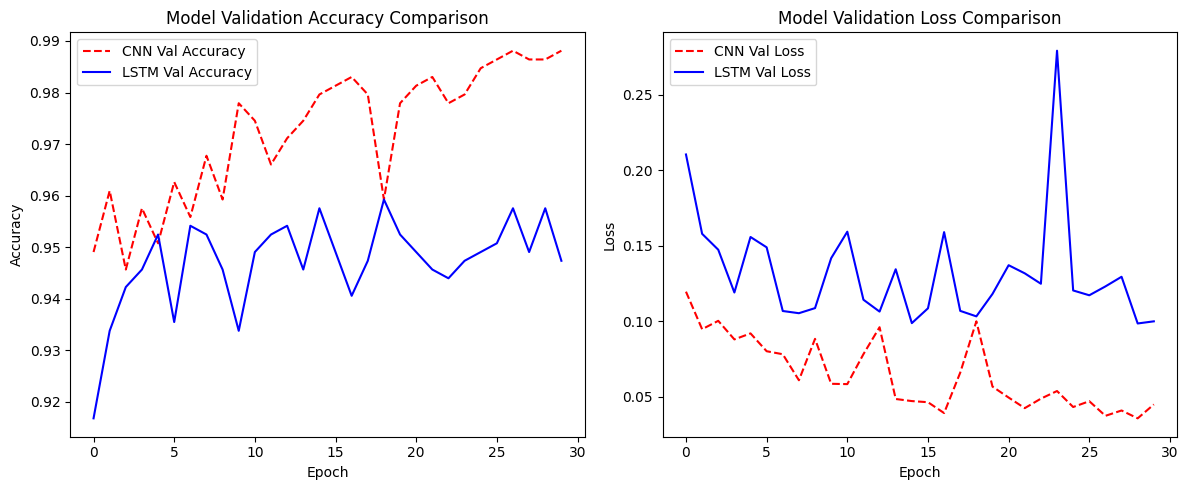


 1. CNN 모델 최종 평가 (Test Set)
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Test Accuracy (CNN): 95.42%

Classification Report (CNN):
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       496
           1       0.93      0.99      0.96       471
           2       0.98      0.97      0.98       420
           3       0.93      0.87      0.90       491
           4       0.89      0.94      0.91       532
           5       1.00      1.00      1.00       537

    accuracy                           0.95      2947
   macro avg       0.96      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947


Confusion Matrix (CNN):
[[475  15   3   0   3   0]
 [  1 464   5   1   0   0]
 [  1  10 409   0   0   0]
 [  0   6   0 428  57   0]
 [  0   2   0  31 499   0]
 [  0   0   0   0   0 537]]

 2. LSTM 모델 최종 평가 (Test Set)
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Test Accuracy (LSTM): 93.32%

Classification Report (LSTM):
            

In [14]:
# -----------------------------------------------------------------
# 5. 훈련 과정 시각화 (비교)
# -----------------------------------------------------------------

plt.figure(figsize=(12, 5))

# 정확도 비교
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['val_accuracy'], 'r--', label='CNN Val Accuracy')
plt.plot(lstm_history.history['val_accuracy'], 'b-', label='LSTM Val Accuracy')
plt.title('Model Validation Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# 손실 비교
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['val_loss'], 'r--', label='CNN Val Loss')
plt.plot(lstm_history.history['val_loss'], 'b-', label='LSTM Val Loss')
plt.title('Model Validation Loss Comparison')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()


# -----------------------------------------------------------------
# 6. 최종 평가 및 비교
# -----------------------------------------------------------------

# --- CNN 평가 ---
print("\n" + "="*30)
print(" 1. CNN 모델 최종 평가 (Test Set)")
print("="*30)
pred_cnn_probs = cnn3_model.predict(testX)
pred_cnn = np.argmax(pred_cnn_probs, axis=-1)
acc_cnn = accuracy_score(testy, pred_cnn)

print(f"\nTest Accuracy (CNN): {acc_cnn * 100:.2f}%")
print("\nClassification Report (CNN):")
print(classification_report(testy, pred_cnn))
print("\nConfusion Matrix (CNN):")
print(confusion_matrix(testy, pred_cnn))


# --- LSTM 평가 ---
print("\n" + "="*30)
print(" 2. LSTM 모델 최종 평가 (Test Set)")
print("="*30)
pred_lstm_probs = lstm_model.predict(testX)
pred_lstm = np.argmax(pred_lstm_probs, axis=-1)
acc_lstm = accuracy_score(testy, pred_lstm)

print(f"\nTest Accuracy (LSTM): {acc_lstm * 100:.2f}%")
print("\nClassification Report (LSTM):")
print(classification_report(testy, pred_lstm))
print("\nConfusion Matrix (LSTM):")
print(confusion_matrix(testy, pred_lstm))


# --- 최종 요약 ---
print("\n" + "="*30)
print(" 최종 비교 요약")
print("="*30)
print(f"CNN Test Accuracy: {acc_cnn * 100:.2f}%")
print(f"Stacked LSTM Test Accuracy:  {acc_lstm * 100:.2f}%")